## Libraries and data import

In [1]:
# Imports
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import numpy
import math
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation, merge
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
import keras.backend as K
from natsort import natsorted, ns
import keras
import PIL
from keras.regularizers import l2
from glob import glob
from keras.applications import vgg16, resnet50
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, LearningRateScheduler
from matplotlib import pyplot
import tensorflow as tf
from sklearn.model_selection import train_test_split

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

Using TensorFlow backend.


In [2]:
# Data path
data = "../../coral_img/"

# Train and test directories
train_dir = data + "train/"
test_dir = data + "Test_Mixed/"

## Seeds and model parameters

In [3]:
# Fijar las semillas
seed = 2032 # Semilla del numpy
tf.set_random_seed(seed) # Fijar semilla del keras/tensorflow

epochs = 500
batch_size = 32

model_name = 'model.h5'

## Brightness fix through YCrCb color space

In [4]:
def brightness_fix(img):
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_YCrCb = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    cl1 = clahe.apply(img_YCrCb[:,:,0])
    
    img_YCrCb[:,:,0] = cl1         
    img_RGB_2 = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
    
    img_blur = cv2.GaussianBlur(img_RGB_2, (5, 5), 0)
    
    return img_blur

## Data import and normalization

In [5]:
# Classes
clases = sorted(os.listdir(train_dir))

# Train data import
x_train = np.array([brightness_fix(cv2.imread(os.path.join(train_dir, cl, name), cv2.IMREAD_COLOR)) for cl in clases
           for name in os.listdir(os.path.join(train_dir, cl))])
y_lab = np.array([n for n, cl in enumerate(clases)
           for name in os.listdir(os.path.join(train_dir, cl))])

# Train data shuffle
idx = np.random.permutation(len(x_train))
x_train, y_lab = x_train[idx], y_lab[idx]

# One hot encoding
y_train = to_categorical(y_lab, dtype=int)

# Train and validation set
#x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,stratify=y_train,test_size=0.2, random_state = 69)

# Test data import
test_files = natsorted(os.listdir(test_dir))
x_test = np.array([brightness_fix(cv2.imread(os.path.join(test_dir, name), cv2.IMREAD_COLOR)) for name in test_files])

## Data augmentation

In [6]:
# Data generator
datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    validation_split=0.2
    #zoom_range=0.4,
    #horizontal_flip=True,
)

# Validation and test set normalization
datagen.fit(x_train)

#x_validation = (x_validation - datagen.mean)/(datagen.std + 0.000001)
x_test = (x_test - datagen.mean)/(datagen.std + 0.000001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


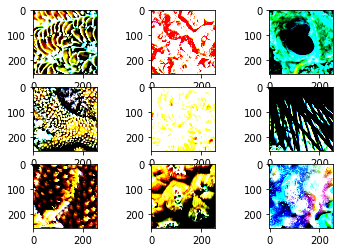

In [7]:
for X_batch, y_batch in datagen.flow(x_train, y_train):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i])
    pyplot.show()
    break

## Load model

In [8]:
# create the base pre-trained model
base_model = resnet50.ResNet50(weights='imagenet',include_top=False, input_shape=(256,256,3))

base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/jisern/venv/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Add transfer learning layers

In [9]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(rate=0.3)(x)
x=Dense(1024, activation='relu')(x)
x=Dropout(rate=0.5)(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(14,activation='softmax')(x) 

model=Model(inputs=base_model.input, outputs=preds)

for i,layer in enumerate(model.layers):
    print(i,layer.name)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 pool1_pad
6 max_pooling2d_1
7 res2a_branch2a
8 bn2a_branch2a
9 activation_2
10 res2a_branch2b
11 bn2a_branch2b
12 activation_3
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_1
18 activation_4
19 res2b_branch2a
20 bn2b_branch2a
21 activation_5
22 res2b_branch2b
23 bn2b_branch2b
24 activation_6
25 res2b_branch2c
26 bn2b_branch2c
27 add_2
28 activation_7
29 res2c_branch2a
30 bn2c_branch2a
31 activation_8
32 res2c_branch2b
33 bn2c_branch2b
34 activation_9
35 res2c_branch2c
36 bn2c_branch2c
37 add_3
38 activation_10
39 res3a_branch2a
40 bn3a_branch2a
41 activation_11
42 res3a_branch2b
43 bn3a_branch2b
44 activation_12
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_4
50 activation_13
51 res3b_branch2a
52 bn3b_branch2a
53 activation_14
54 res3b_branch2b
55 bn3b_branch

In [10]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
        
for layer in model.layers[165:]:
    layer.trainable=True

# compile the model (should be done *after* setting layers to non-trainable)
learning_rate = 0
decay_rate = 0
momentum = 0.9

opt_SGD = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
opt_Adam = Adam(lr=0.000007) 

model.compile(loss='categorical_crossentropy', optimizer=opt_Adam,metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Run model

In [11]:
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=10, restore_best_weights = True)

def step_decay(epoch):
    if epoch < 15:
        epochs_drop = 30.0
    else:
        epochs_drop = 10.0
    initial_lrate = 0.0001
    drop = 0.5
    
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

step_decay_callback = LearningRateScheduler(step_decay)

callback_list = [early_stopping_callback]

# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                   steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
#                   validation_data = (x_validation, y_validation),
#                   validation_steps = len(x_validation) / batch_size,
#                   verbose=1, callbacks=callback_list)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, subset="training"),
                   steps_per_epoch=int(len(x_train)*0.8) / batch_size, epochs=epochs,
                   validation_data = datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation'),
                   validation_steps = int(len(x_train)*0.2) / batch_size,
                   verbose=1, callbacks=callback_list)

model.save(model_name)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
16/15 [==============================] - 12s 719ms/step - loss: 3.0217 - acc: 0.0741 - val_loss: 2.6747 - val_acc: 0.0968
Epoch 2/500
16/15 [==============================] - 4s 232ms/step - loss: 2.8825 - acc: 0.1092 - val_loss: 2.5352 - val_acc: 0.1694
Epoch 3/500
16/15 [==============================] - 4s 232ms/step - loss: 2.7246 - acc: 0.1076 - val_loss: 2.4182 - val_acc: 0.2419
Epoch 4/500
16/15 [==============================] - 4s 232ms/step - loss: 2.6173 - acc: 0.1250 - val_loss: 2.3114 - val_acc: 0.2581
Epoch 5/500
16/15 [==============================] - 4s 232ms/step - loss: 2.4588 - acc: 0.2012 - val_loss: 2.2143 - val_acc: 0.2903
Epoch 6/500
16/15 [==============================] - 4s 232ms/step - loss: 2.4602 - acc: 0.1874 - val_loss: 2.1226 - val_acc: 0.3710
Epoch 7/500
16/15 [==============================] - 4s 232ms/step - loss: 2.3239 - acc: 0.2365 - val_loss: 2.0422 - val_acc: 0.4113
Epoch 8/500
16/15 [=

16/15 [==============================] - 4s 233ms/step - loss: 0.3476 - acc: 0.9335 - val_loss: 0.3052 - val_acc: 0.9435
Epoch 61/500
16/15 [==============================] - 4s 233ms/step - loss: 0.3355 - acc: 0.9395 - val_loss: 0.2980 - val_acc: 0.9435
Epoch 62/500
16/15 [==============================] - 4s 233ms/step - loss: 0.3221 - acc: 0.9648 - val_loss: 0.2890 - val_acc: 0.9435
Epoch 63/500
16/15 [==============================] - 4s 233ms/step - loss: 0.3125 - acc: 0.9375 - val_loss: 0.2790 - val_acc: 0.9435
Epoch 64/500
16/15 [==============================] - 4s 233ms/step - loss: 0.3439 - acc: 0.9319 - val_loss: 0.2730 - val_acc: 0.9435
Epoch 65/500
16/15 [==============================] - 4s 233ms/step - loss: 0.3114 - acc: 0.9454 - val_loss: 0.2668 - val_acc: 0.9435
Epoch 66/500
16/15 [==============================] - 4s 233ms/step - loss: 0.2792 - acc: 0.9532 - val_loss: 0.2595 - val_acc: 0.9435
Epoch 67/500
16/15 [==============================] - 4s 233ms/step - loss:

16/15 [==============================] - 4s 233ms/step - loss: 0.0933 - acc: 0.9806 - val_loss: 0.0857 - val_acc: 0.9839
Epoch 122/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0859 - acc: 0.9787 - val_loss: 0.0829 - val_acc: 0.9839
Epoch 123/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0761 - acc: 0.9846 - val_loss: 0.0820 - val_acc: 0.9839
Epoch 124/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0561 - acc: 0.9961 - val_loss: 0.0813 - val_acc: 0.9839
Epoch 125/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0760 - acc: 0.9883 - val_loss: 0.0810 - val_acc: 0.9839
Epoch 126/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0745 - acc: 0.9865 - val_loss: 0.0795 - val_acc: 0.9839
Epoch 127/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0704 - acc: 0.9961 - val_loss: 0.0773 - val_acc: 0.9839
Epoch 128/500
16/15 [==============================] - 4s 233ms/step 

Epoch 182/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0205 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 0.9919
Epoch 183/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0163 - acc: 1.0000 - val_loss: 0.0522 - val_acc: 0.9919
Epoch 184/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0259 - acc: 0.9903 - val_loss: 0.0518 - val_acc: 0.9919
Epoch 185/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0163 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9919
Epoch 186/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0179 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9919
Epoch 187/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0265 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9919
Epoch 188/500
16/15 [==============================] - 4s 233ms/step - loss: 0.0215 - acc: 0.9941 - val_loss: 0.0501 - val_acc: 0.9919
Epoch 189/500
16/15 [==============================] - 

In [12]:

predictions_test = model.predict(x_test, verbose=1)

data = pd.DataFrame()
data['Id'] = test_files
data['Category'] = predictions_test.argmax(axis=-1)


data.to_csv("envio.csv", index=False)

146/146 [==============================] - 1s 10ms/step


In [13]:
conversion = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'j': 9,
    'k': 10,
    'l': 11,
    'm': 12,
    'n': 13
}
classes = []
for t in test_files:
    class_ = t.split("T")[0]
    classes.append(conversion[class_])

from sklearn.metrics import accuracy_score
print(accuracy_score(classes, data['Category']))

0.9315068493150684
